In [1]:
import statistics
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import unidecode
import re

from wordcloud import WordCloud
from nltk import tokenize

# fixa a imagem no notebook
%matplotlib inline

Based on the exploration, I chose the Train500.csv file and Test.csv as dataset. They have 505 thousand tweets together !!
* 0 = sentimento NEGATIVO
* 1 = sentimento POSITIVO

#### Fetches the dataset

In [2]:
train = pd.read_csv('dataset/TrainingDatasets/Train500.csv',delimiter=';')
tests = pd.read_csv('dataset/TestDatasets/Test.csv',delimiter=';')
dataset = pd.concat([train, tests], ignore_index=True)

In [3]:
len(dataset)

505000

In [4]:
dataset.sample(5)

,id,tweet_text,tweet_date,sentiment,query_used
450481,1040743812153450497,Quando eu decido ir no jubileu começa a chover :(,Fri Sep 14 23:27:15 +0000 2018,0,:(
337218,1043680725743034369,@YaoiSociety serem ah :(,Sun Sep 23 01:57:30 +0000 2018,0,:(
277407,1046721793095061506,"Contente por ti, triste por mim :(((((((( http...",Mon Oct 01 11:21:37 +0000 2018,0,:(
153873,1037424653327912960,Curti bastante o Chrome 69 :D As alterações na...,Wed Sep 05 19:38:06 +0000 2018,1,:)
100592,1042033206139207680,Bom dia pessoal! Hoje a prova deu bom então já...,Tue Sep 18 12:50:51 +0000 2018,1,:)


### Deletes repeated tweets

In [5]:
dataset.drop_duplicates(subset='id', keep = False, inplace = True)
dataset.drop_duplicates(subset='tweet_text', keep = False, inplace = True)

### Deletes null tweets

In [6]:
dataset.dropna()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)
...,...,...,...,...,...
504995,1030528364145201153,@ol_cdanilo parece livro de autoajuda :(,Fri Aug 17 18:54:42 +0000 2018,0,:(
504996,1030528418235015168,@tatazoquita aaaaa sinto muito :((,Fri Aug 17 18:54:55 +0000 2018,0,:(
504997,1030528446122930176,To começando a sentir dor de novo e meu irmão ...,Fri Aug 17 18:55:02 +0000 2018,0,:(
504998,1030528453752352769,@ichbintw parece que no dia que toma a vacina ...,Fri Aug 17 18:55:04 +0000 2018,0,:(


### Deletes some columns that are not important

In [7]:
dataset.drop(columns = ["id" ,"tweet_date","query_used"], axis = 1 , inplace = True)

In [8]:
print(dataset.sentiment.value_counts())

0    249137
1    248116
Name: sentiment, dtype: int64


### Put everything in lower case

In [9]:
for index, row in dataset.iterrows():
    dataset.at[index,'tweet_text'] = row['tweet_text'].lower()

### Eliminates stop words


In [10]:
# we download the most common stop words in Portuguese
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("portuguese")
print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'est

In [11]:
for index, row in dataset.iterrows():
    # regex: returns only the words, ":)", ":(" and ": /"
    # eliminate cue points
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in stop_words]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Remove the accentuation of words

In [12]:
for index, row in dataset.iterrows():
    dataset.at[index,'tweet_text'] = unidecode.unidecode(row['tweet_text'])

### Delete words with @
The profile names

In [13]:
for index, row in dataset.iterrows():
    # regex: returns only words starting with @
    words_with_arroba = re.findall(r"\@\w+", row['tweet_text'])
    # regex: returns all words, :), :(,: / and removes the flags
    all_words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in all_words if ws not in words_with_arroba]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Eliminates words with numbers

dataset example: '48e433a0-ead1-44f3-9f45-e0e5ea48cfb2'

In [14]:
for index, row in dataset.iterrows():
    words_with_numbers = re.findall(r"\S*\d+\S*", row['tweet_text'])
    all_words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in all_words if ws not in words_with_numbers]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Does the Stemization
Which is to extract only the radicals from words, so we can avoid the contractions and flexions of words

In [15]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


True

In [16]:
stemmer = nltk.RSLPStemmer()

for index, row in dataset.iterrows():
    #returns only the words - eliminating signal pnts
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [stemmer.stem(ws) for ws in words]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Function Word Cloud

In [17]:
def word_cloud(data):
    text = [str(text) for text in data]

    # um texto enorme, com todas as resenhas
    all_ = ' '.join(text)
    cloud_words = WordCloud(
        width = 500 , height = 300 , 
               max_font_size = 100,
                           collocations = False).generate(all_)


    plt.figure(figsize = (10,8))
    plt.imshow(cloud_words , interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

### Function - Token counter

In [18]:
def count_tokens(data):
    text = [str(text) for text in data]
    all_ = ''
    all_ = ' '.join(text)

    tokenizador = tokenize.WhitespaceTokenizer()
    tokens = tokenizador.tokenize(all_)

    frequencia = nltk.FreqDist(tokens)

    df_frequencia = pd.DataFrame({
        "Palavra" : list(frequencia.keys()),
        "Frequência" : list(frequencia.values())
    })

    ## mostra as palavras de maior frequencia
    most_frequency = df_frequencia.nlargest(
        columns = "Frequência" , 
        n = 10)

    return most_frequency

# Analyze

In [19]:
tweets_positivos = dataset.query('sentiment == 1')
tweets_negativos = dataset.query('sentiment == 0')

## Analysis of positive tweets

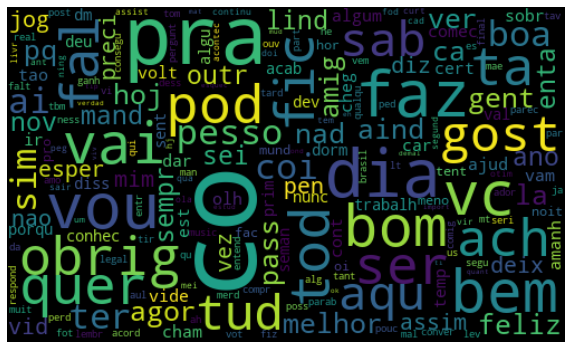

In [20]:
word_cloud(tweets_positivos.tweet_text)

In [21]:
count_tokens(tweets_positivos.tweet_text)

,Palavra,Frequência
4,:),202105
26,t,57359
25,:/,57357
27,co,57149
24,http,56944
34,d,30077
123,pra,24946
75,p,18625
148,dia,15915
13,faz,14670


## Analysis of negative tweets

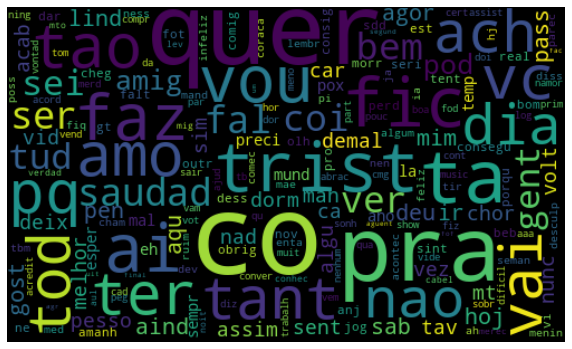

In [22]:
word_cloud(tweets_negativos.tweet_text)

In [23]:
count_tokens(tweets_negativos.tweet_text)

,Palavra,Frequência
1,:(,249248
51,:/,41083
52,t,41037
53,co,40806
50,http,40694
10,quer,32313
79,to,26314
25,pra,25600
93,q,17274
29,ta,16200


## Let's delete the words that appear frequently in the 2 classes of feeling

In [24]:
# funcao que retorna as N palavras mais frequentes de um texto
def get_n_most_frequency(n,data):
    text = [str(text) for text in data]
    all_ = ''
    all_ = ' '.join(text)

    tokenizador = tokenize.WhitespaceTokenizer()
    tokens = tokenizador.tokenize(all_)

    frequencia = nltk.FreqDist(tokens)

    df_frequencia = pd.DataFrame({
        "Palavra" : list(frequencia.keys()),
        "Frequência" : list(frequencia.values())
    })

    ## mostra as palavras de maior frequencia
    most_frequency = df_frequencia.nlargest(
        columns = "Frequência" , 
        n = n)

    list_n_most_frequency = most_frequency.Palavra
    return list(list_n_most_frequency)

In [25]:
most_frequency_positivo = get_n_most_frequency(10,tweets_positivos.tweet_text)
most_frequency_negativo = get_n_most_frequency(10,tweets_negativos.tweet_text)
equal = list(set(most_frequency_positivo) & set(most_frequency_negativo))
equal

[':/', 'co', 'pra', 'http', 't']

In [26]:
for index, row in dataset.iterrows():
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in equal]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

In [27]:
tweets_positivos = dataset.query('sentiment == 1')
tweets_negativos = dataset.query('sentiment == 0')

In [28]:
count_tokens(tweets_positivos.tweet_text)

,Palavra,Frequência
4,:),202105
30,d,30077
71,p,18625
143,dia,15915
13,faz,14670
297,q,14559
12,vou,14164
48,vc,13168
217,bem,12854
232,bom,11889


In [29]:
count_tokens(tweets_negativos.tweet_text)

,Palavra,Frequência
1,:(,249248
10,quer,32313
74,to,26314
88,q,17274
28,ta,16200
20,fic,13894
21,trist,13874
31,ai,13175
57,vou,12479
64,faz,12448


## Average number of words per tweet

In [30]:
buf = []
for index, row in dataset.iterrows():
    buf.append(len(row['tweet_text'].split()))

statistics.mean(buf)

8.069095611288418

In [31]:
max(buf)

54

In [32]:
min(buf)

0

### Delete tweet with zero size content

In [33]:
for index, row in dataset.iterrows():
    tam = len(row['tweet_text'].split())
    if tam == 0:
        dataset.drop(index, inplace=True)


### Deletes isolated letters from the tweet
Example: ola c t vc

In [34]:
for index, row in dataset.iterrows():
    only_letter = re.findall(r"\b[a-z]\b", row['tweet_text'])
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in only_letter]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Delete words that are made up of the same letter
Example: aaaaaaaaaa kkkkkkk rrrrrr uuuuuuuu uuuuuuuuu

In [35]:
for index, row in dataset.iterrows():
    word_same_letter = re.findall(
        r"\ba{2,}\b|\bb{2,}\b|\bc{2,}\b|\bd{2,}\b|\be{2,}\b|\bf{2,}\b|\bg{2,}\b|\bh{2,}\b|\bi{2,}\b|\bj{2,}\b|\bk{2,}\b|\bl{2,}\b|\bm{2,}\b|\bn{2,}\b|\bo{2,}\b|\bp{2,}\b|\bq{2,}\b|\br{2,}\b|\bs{2,}\b|\bt{2,}\b|\bu{2,}\b|\bv{2,}\b|\bw{2,}\b|\bx{2,}\b|\by{2,}\b|\bz{2,}\b",
        row['tweet_text'])
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in word_same_letter]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

In [36]:
dataset.head(5)

,tweet_text,sentiment
0,pesso cert val azeved :),1
1,mim precis contrari :) vem chuv vem boa dispos...,1
2,vou faz vide hoj pens fal pouc sobr nov met cs...,1
3,ame tant polaroid sei express quant to apaixon...,1
4,valoriz coraca menin vc difer fac sorr ter cer...,1


In [37]:
dataset.to_csv(r'treated_dataset.csv',index=False)